In [4]:
%pip install cryptography

Note: you may need to restart the kernel to use updated packages.


In [5]:
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.serialization import Encoding, ParameterFormat, PublicFormat
from cryptography.hazmat.primitives.serialization import load_pem_parameters, load_pem_public_key
from cryptography.hazmat.primitives.kdf.hkdf import HKDF

In [21]:
%%time
with open ("shared_file", "rb") as file:
    parameters = load_pem_parameters(file.read()) 
    
private_key_D = parameters.generate_private_key()
public_mixed_with_D = private_key_D.public_key()

with open("shared_file", "wb") as file:
    file.write(public_mixed_with_D.public_bytes(encoding=Encoding.PEM, format=PublicFormat.SubjectPublicKeyInfo))

CPU times: total: 0 ns
Wall time: 3.17 ms


In [22]:
%%time
with open ("shared_file", "rb") as file:
    public_mixed_with_C = load_pem_public_key(file.read()) 

CPU times: total: 0 ns
Wall time: 0 ns


In [68]:
%%time
shared_key_C_then_D = private_key_D.exchange(public_mixed_with_C) # brown

derived_key_C_then_D = HKDF(
    algorithm = hashes.SHA256(),
    length=32,
    salt=None,
    info=b'handshake data',
    backend=default_backend()
).derive(shared_key_C_then_D)

CPU times: total: 0 ns
Wall time: 1 ms


### Decryption without Integrity and Authenticity

In [9]:
from Crypto.Cipher import AES
from Crypto.Util import Counter
from io import StringIO
import pandas as pd

In [55]:
%%time
with open ("shared_file", "rb") as file:
    columns_desc_enc = file.read()

CPU times: total: 0 ns
Wall time: 1.01 ms


In [57]:
%%time
def decrypt_csv_ctr(ct, key, counter_iv, counter_size=128):
    counter = Counter.new(counter_size, initial_value=counter_iv)    
    aes = AES.new(key=key, mode=AES.MODE_CTR, counter=counter)
    return aes.decrypt(ct)

columns_desc = pd.read_csv(StringIO(decrypt_csv_ctr(columns_desc_enc, derived_key_C_then_D, 10).decode('utf-8')))

CPU times: total: 0 ns
Wall time: 3.47 ms


In [58]:
%%time
with open ("shared_file", "rb") as file:
    infringement_dataset_enc = file.read()

infringement_dataset = pd.read_csv(StringIO(decrypt_csv_ctr(infringement_dataset_enc, derived_key_C_then_D, 10).decode('utf-8')))

CPU times: total: 0 ns
Wall time: 12.6 ms


### Decryption with Integrity and Authenticity

In [60]:
from cryptography.hazmat.primitives.ciphers.aead import AESGCM
from io import StringIO
import pandas as pd

In [61]:
%%time
with open ("shared_file", "rb") as file:
    columns_desc_enc = file.read()

CPU times: total: 0 ns
Wall time: 0 ns


In [62]:
%%time
with open ("shared_file", "rb") as file:
    nonce = file.read()

aesgcm = AESGCM(derived_key_C_then_D)
columns_dataset = pd.read_csv(StringIO(aesgcm.decrypt(nonce, columns_desc_enc, None).decode("utf-8")))

CPU times: total: 0 ns
Wall time: 992 µs


In [63]:
%%time
with open ("shared_file", "rb") as file:
    infringement_dataset_enc = file.read()

CPU times: total: 46.9 ms
Wall time: 49.6 ms


In [64]:
%%time
with open ("shared_file", "rb") as file:
    nonce = file.read()

infringement_dataset = pd.read_csv(StringIO(aesgcm.decrypt(nonce, infringement_dataset_enc, None).decode("utf-8")))

CPU times: total: 719 ms
Wall time: 1.98 s


### Data analysis

In [47]:
import seaborn as sns
from matplotlib import pyplot as plt

<AxesSubplot:>

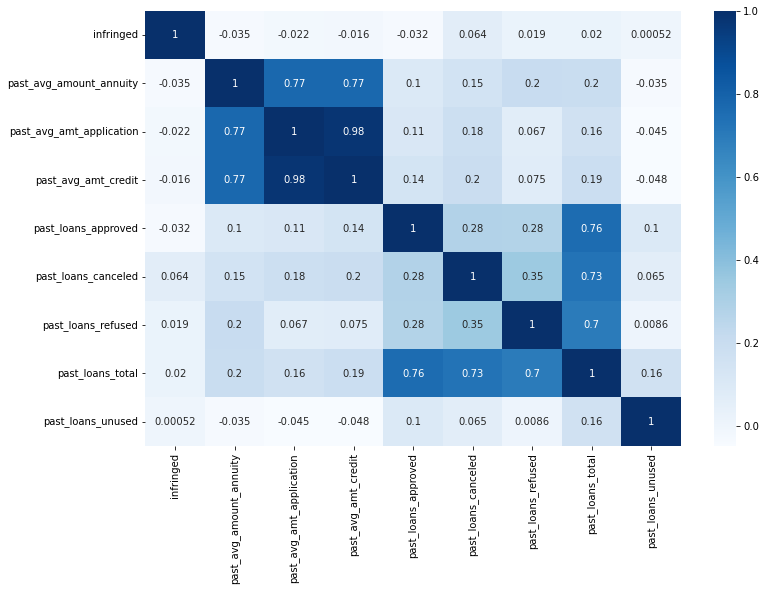

In [65]:
df = infringement_dataset[['infringed', 'past_avg_amount_annuity', 'past_avg_amt_application', 'past_avg_amt_credit', 'past_loans_approved', 'past_loans_canceled', 'past_loans_refused', 'past_loans_total', 'past_loans_unused']]

corr = df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Blues", annot=True)

<AxesSubplot:title={'center':'Percentagem de clientes com determinada idade com empréstimos em incumprimento'}, xlabel='age', ylabel='Percentagem de empréstimos em incumprimento'>

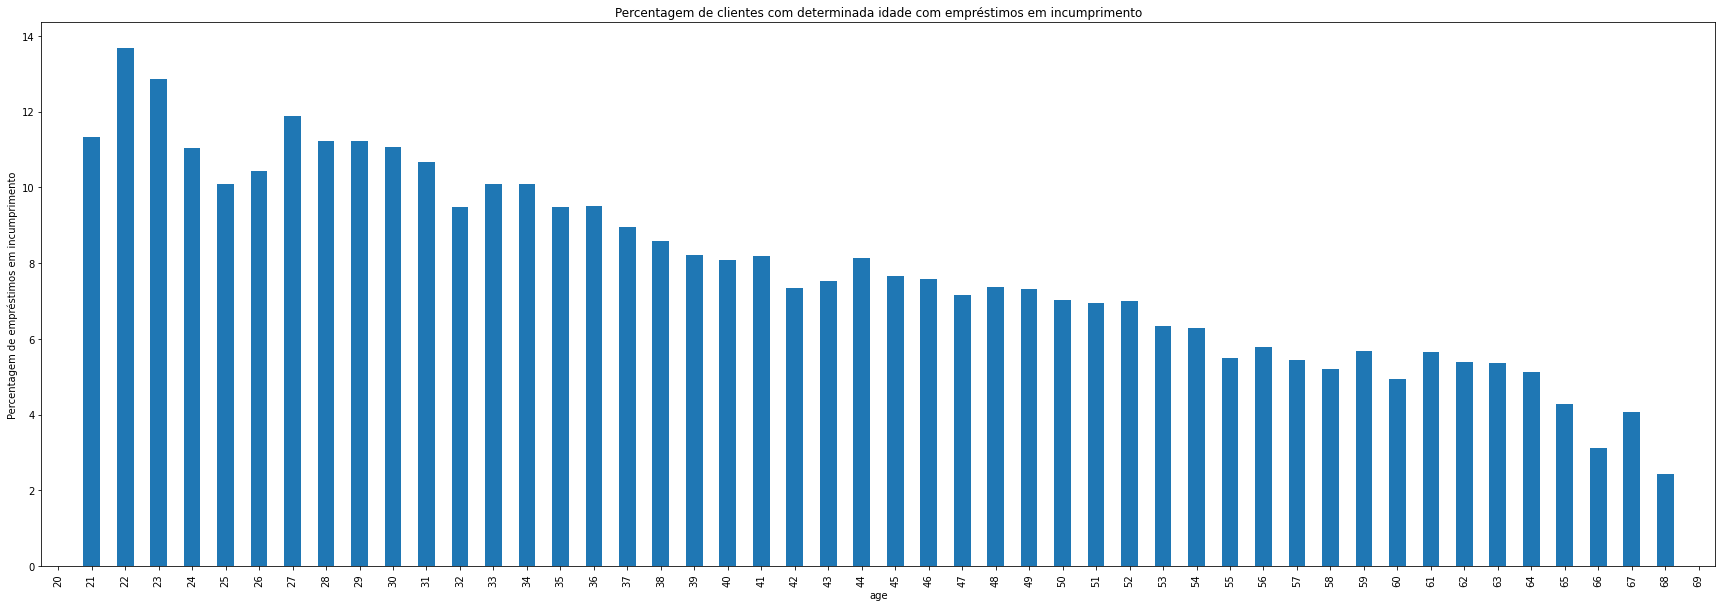

In [67]:
count_inf = infringement_dataset[infringement_dataset['infringed']==1.0].groupby(['age']).size()

age = infringement_dataset.groupby(['age']).size()


plt.title("Percentagem de clientes com determinada idade com empréstimos em incumprimento")
plt.xlabel("Idade dos clientes")
plt.ylabel("Percentagem de empréstimos em incumprimento")

((count_inf/age)*100).plot(figsize=(30,10), kind='bar')
